In [1]:
import pandas as pd
import pandas_datareader as data
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

import requests

from datetime import datetime, timedelta
import time

In [11]:
def get_data(coin, tick_interval = '1h'):
    #Download data from binance brooker
    try:
        market = coin+'USDT' #coins needs to be in pair with other coin. I use USDT that is thether backed by an equivalent amount of U.S. dollars. It's price is pegged to 1 USD.
        url = 'https://api.binance.com/api/v3/klines?symbol='+market+'&interval='+tick_interval
        data = requests.get(url).json() #request data from url specified above and store as json file
        data = pd.DataFrame(data) #convert it to DataFrame for easier manipulation
        data = data.astype(float) #convert format of data to float (binance returns data as strings)
        #first column is datetime saved as UNIX value. I want standard pandas datetime format so that is what I do in line below.
        data[0] = pd.to_datetime(pd.to_datetime(data[0], unit = 'ms', utc = True).dt.tz_convert('Europe/Dublin').dt.strftime('%Y-%m-%d %H:%M:%S'))
        data = data.iloc[:, [0, 4]].rename(columns={0: 'Datetime', 4: coin}) #Keep only first ('Datetime') and fifth ('Close') column and rename them accordingly
        data.set_index('Datetime', inplace=True) #set Datetime column as index
        
        return data
    
    except Exception as e:
        print(e) #print exception if any occurs
        
        
#list of coins that I want to analyze
coins = ['BTC', 'ETH', 'ADA', 'XRP', 'SOL', 'DOT', 'DOGE', 'LUNA', 'UNI', 'BUSD', 'AVAX', 'LTC', 'LINK', 'BCH', 'ALGO', 
         'SHIB', 'MATIC', 'XLM', 'FIL', 'ATOM', 'AXS', 'VET', 'TRX', 'ETC', 'FTT', 'DAI', 'THETA', 'XTZ', 'EGLD']

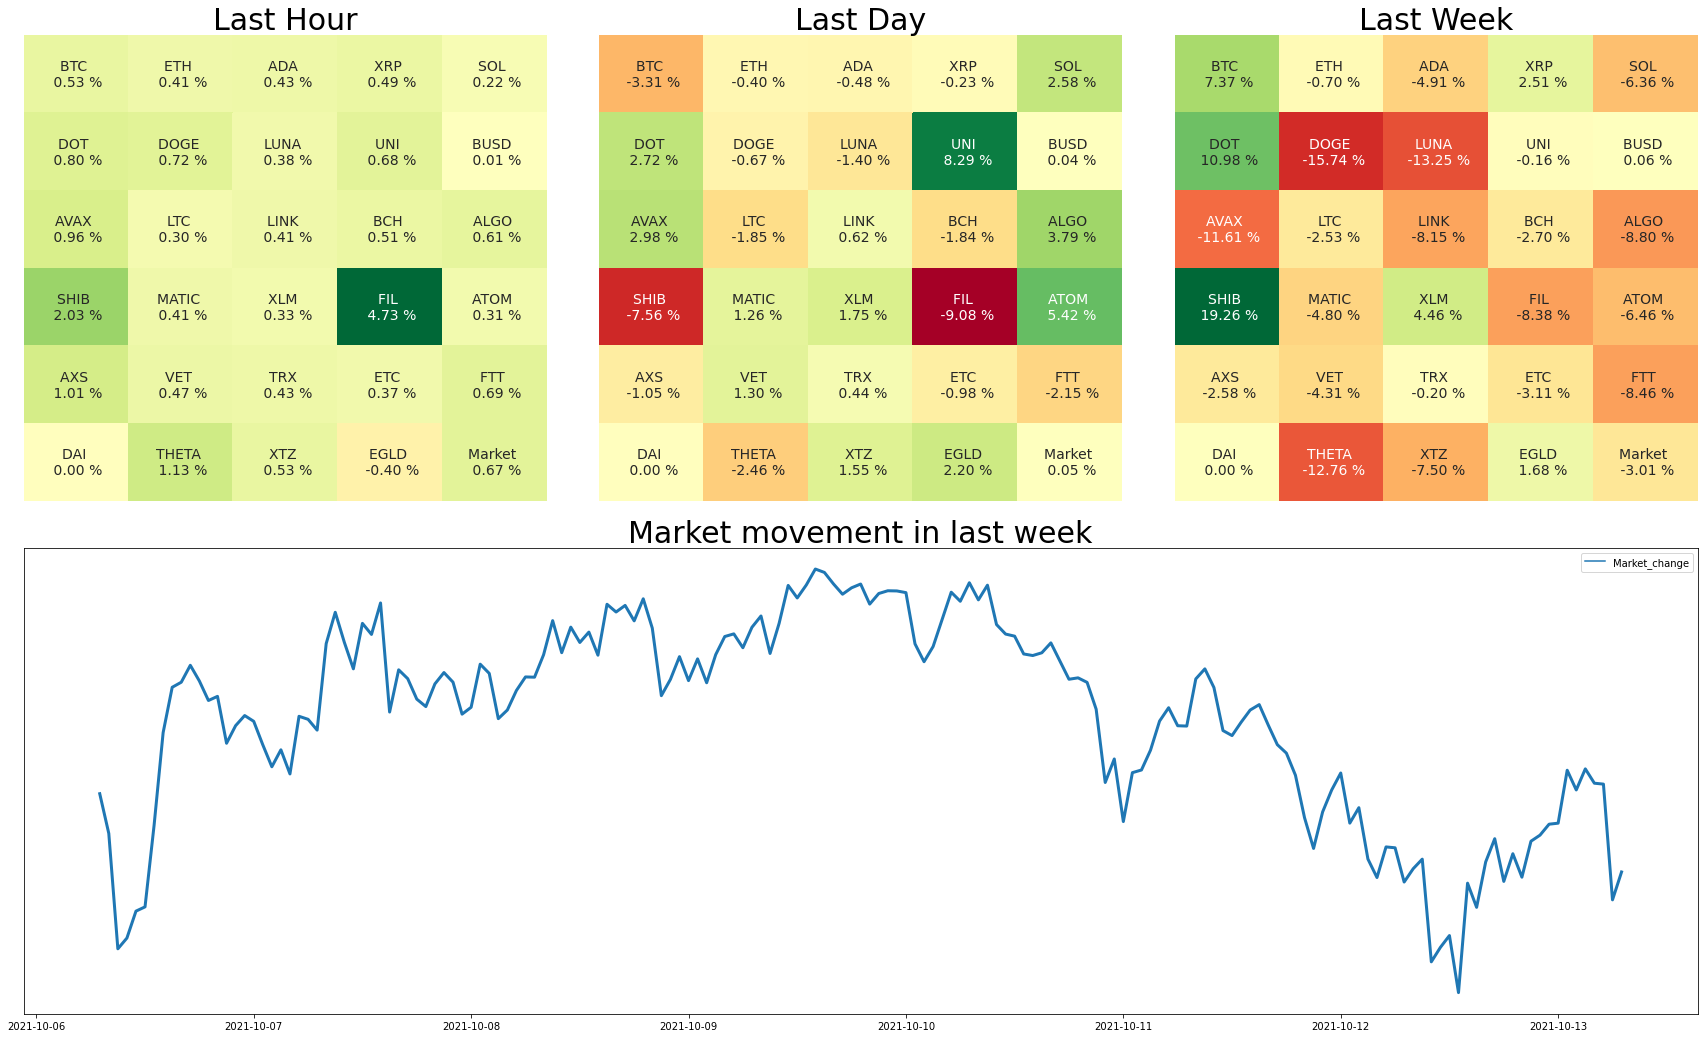

In [12]:
data = [] #empty list where I store data for every coin pair

for coin in coins: #itterate through coins
    if len(data) == 0: #for first coin I simply run get_data function
        data = get_data(coin = coin, tick_interval = '1h')
    else:
        data[coin] = get_data(coin = coin, tick_interval = '1h')[coin] #then for every other coin we need to specify column name where it will add new data

coins = coins + ['Market'] #I want to include Overall Market in heatmap, that's why I add this in to list of coins here

fig = plt.figure(figsize=(30, 18))
gs = fig.add_gridspec(nrows=2, ncols=3, wspace = 0.1, hspace = 0.1) #define how plots will be organized in grid

#LAST HOUR
last_hour_pct = data.pct_change().iloc[-1].fillna(0) * 100 #calculate percentual change in data for last hour (I have hourly data so simply take last row)
last_hour_pct['Market'] = last_hour_pct.mean() #I want overall market movement so I just calculate mean of each pct movement. You can add more sophisticated calculation
pct_diff_h = ((np.asarray(last_hour_pct)).reshape(6, 5)) #I have 29 coins and also Market, that makes 30 datapoints that I want to plot as 6x5 heat map
#to show coin name toghether with percentual change we need to create labels in 6x5 array containing this data. (\n splits data in to 2 rows)
labels_h = (np.asarray(["{0} \n {1:.2f} %".format(coins, pct_diff_h)
            for coins, pct_diff_h in zip(coins, pct_diff_h.flatten())])).reshape(6, 5)

ax1 = fig.add_subplot(gs[0 , 0]) #specify the position of first plot in the grid
sns.heatmap(pct_diff_h, annot = labels_h, fmt="", cmap='RdYlGn', ax = ax1, cbar=False, annot_kws={"size": 14}, center = 0, xticklabels=False, yticklabels = False)
ax1.set_title('Last Hour', size = 30)
ax1.tick_params(left=False, bottom=False)

#LAST DAY
last_day_pct = data.iloc[[-25, -1]].pct_change().iloc[-1].fillna(0) * 100 #calculate percentual change for last day (25 hours gets us to the same hour yesterday)
last_day_pct['Market'] = last_day_pct.mean()
pct_diff_d = ((np.asarray(last_day_pct)).reshape(6, 5))
labels_d = (np.asarray(["{0} \n {1:.2f} %".format(coins, pct_diff_d)
            for coins, pct_diff_d in zip(coins, pct_diff_d.flatten())])).reshape(6, 5)

ax2 = fig.add_subplot(gs[0 , 1])
sns.heatmap(pct_diff_d, annot = labels_d, fmt="", cmap='RdYlGn', ax = ax2, cbar=False, annot_kws={"size": 14}, center = 0, xticklabels=False, yticklabels = False)
ax2.set_title('Last Day', size = 30)
ax2.tick_params(left=False, bottom=False)

#LAST WEEK
last_week_pct = data.iloc[[-169, -1]].pct_change().iloc[-1].fillna(0) * 100 #calculate percentual change for last week (169 hours is 7 days and 1 hour)
last_week_pct['Market'] = last_week_pct.mean()
pct_diff_w = ((np.asarray(last_week_pct)).reshape(6, 5))
labels_w = (np.asarray(["{0} \n {1:.2f} %".format(coins, pct_diff_w)
            for coins, pct_diff_w in zip(coins, pct_diff_w.flatten())])).reshape(6, 5)

ax3 = fig.add_subplot(gs[0 , 2])
sns.heatmap(pct_diff_w, annot = labels_w, fmt="", cmap='RdYlGn', ax = ax3, cbar=False, annot_kws={"size": 14}, center = 0, xticklabels=False, yticklabels = False)
ax3.set_title('Last Week', size = 30)
ax3.tick_params(left=False, bottom=False)

#OVERALL MARKET
pct = data.pct_change() #calculate percentual change for every column in data dataframe
pct['Market_change'] = pct.mean(axis = 1) #then calculate mean of every row and save this values in new column 'Market_change'
pct['Market'] = pct['Market_change'].cumsum() #and finally calculate cumulative sum of this pct changes to get market movement that I can plot

ax4 = fig.add_subplot(gs[1 , 0:])
sns.lineplot(data = pct[['Market_change']].cumsum().iloc[-169:], lw = 3, ax = ax4)
ax4.set_title('Market movement in last week', size = 30)
ax4.set(xlabel=None)
ax4.axes.yaxis.set_visible(False)

plt.show()